first ```conda install -c conda-forge rioxarray```

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import rioxarray as rxr
from rasterio.windows import Window
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import xarray as xr

### 2018 NAIP ###

In [2]:
filepath = '/home/jovyan/UrbanForest'
infile = os.path.join(filepath, 'santa_monica_4bandNAIP_mosaic_originwarp_1m.tiff')
outfile = 'santa_monica_4bandNAIP_mosaic_originwarp_1m_ndvi.tif'

In [3]:
with rio.open(infile, 'r') as src:
    profile = src.profile
    data = src.read()
profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 11946, 'height': 14334, 'count': 4, 'crs': CRS.from_epsg(26911), 'transform': Affine(1.0, 0.0, 355548.0,
       0.0, -1.0, 3770340.0), 'tiled': False, 'interleave': 'pixel'}

In [25]:
#data = rxr.open_rasterio(infile)
data.shape

(4, 14334, 11946)

In [29]:
xdata = xr.DataArray(data)
xdata

<xarray.DataArray (dim_0: 4, dim_1: 14334, dim_2: 11946)>
array([[[ 39,  39,  54, ...,   0,   0,   0],
        [ 56,  51,  54, ...,   0,   0,   0],
        [ 42,  49,  56, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[ 59,  49,  60, ...,   0,   0,   0],
        [ 65,  55,  66, ...,   0,   0,   0],
        [ 56,  60,  71, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[ 67,  66,  69, ...,   0,   0,   0],
        [ 75,  73,  74, ...,   0,   0,   0],
        [ 71,  75,  75, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[108,  67,  95, ...,   0,   0,   0],
        [ 83,  62,  91, ...,   0,   0,   0],
        [102,  78, 112, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]]], dtype=uint8)
Dimensions without coordinates: dim_0, dim_1, dim_2

In [5]:
#!gdalinfo /home/jovyan/UrbanForest/santa_monica_4bandNAIP_mosaic_originwarp_1m.tiff

In [6]:
ndvi = es.normalized_diff(data[3], data[0])

/opt/conda/lib/python3.8/site-packages/earthpy/spatial.py:105: RuntimeWarning: invalid value encountered in true_divide
  n_diff = (b1 - b2) / (b1 + b2)
/opt/conda/lib/python3.8/site-packages/earthpy/spatial.py:109: Warning: Divide by zero produced infinity values that will be replaced with nan values
  warnings.warn(


In [23]:
ndvi
#data= data.where(data != np.inf)
#data_masked

array([[ 4.69387755e-01,  2.64150943e-01,  2.75167785e-01, ...,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03],
       [ 1.94244604e-01,  9.73451327e-02,  2.55172414e-01, ...,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03],
       [ 4.16666667e-01,  2.28346457e-01,  3.33333333e-01, ...,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03],
       ...,
       [-9.99900000e+03, -9.99900000e+03, -9.99900000e+03, ...,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03],
       [-9.99900000e+03, -9.99900000e+03, -9.99900000e+03, ...,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03],
       [-9.99900000e+03, -9.99900000e+03, -9.99900000e+03, ...,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03]])

gdalinfo gives us:
```
Band 1 Block=11946x1 Type=Byte, ColorInterp=Red
Band 2 Block=11946x1 Type=Byte, ColorInterp=Green
Band 3 Block=11946x1 Type=Byte, ColorInterp=Blue
Band 4 Block=11946x1 Type=Byte, ColorInterp=Undefined
```

4 is near IR

In [8]:
#ndvi = es.normalized_diff(data_masked[3], data_masked[0])

In [9]:
ndvi = ndvi.filled(-9999)

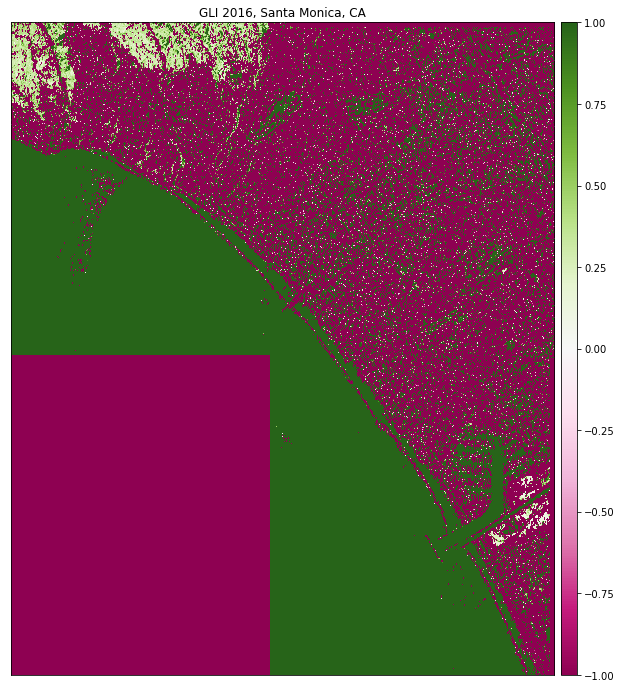

In [10]:
ep.plot_bands(ndvi,
              cmap='PiYG',
              scale=False,
              vmin=-1, vmax=1,
              title='GLI 2016, Santa Monica, CA');

In [21]:
ndvi[ndvi > -9998].min()

0.0

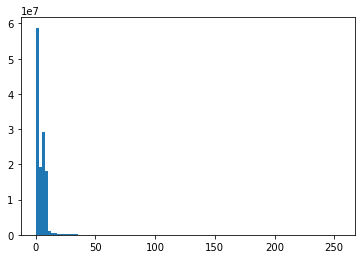

In [18]:
flat = ndvi.flatten()
ax = plt.hist(flat[flat > -1], bins=100);
#plt.xlim(-1,1);

It looks like the bottom bump is water, the middle bump is built environment and the upper bumb is vegetation.  Lets use 0.25 as a cuttoff for masking. the CHM.  But first we will write a geotiff of ndvi.

In [61]:
ndvi.shape

(14334, 11946)

Reshape it for rasterio.

In [67]:
ndvi_ = ndvi.reshape(1, 14334, 11946)
with rio.open(outfile, 'w', **profile) as dst:
        dst.write(ndvi.astype(rio.uint8), 1)

In [57]:
?rasterio.uint8

Object `rasterio.uint8` not found.


In [51]:
ndvi

array([[ 4.69387755e-01,  2.64150943e-01,  2.75167785e-01, ...,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03],
       [ 1.94244604e-01,  9.73451327e-02,  2.55172414e-01, ...,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03],
       [ 4.16666667e-01,  2.28346457e-01,  3.33333333e-01, ...,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03],
       ...,
       [-9.99900000e+03, -9.99900000e+03, -9.99900000e+03, ...,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03],
       [-9.99900000e+03, -9.99900000e+03, -9.99900000e+03, ...,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03],
       [-9.99900000e+03, -9.99900000e+03, -9.99900000e+03, ...,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03]])

In [15]:
type(ndvi)

numpy.ndarray

In [56]:
!pwd

/home/jovyan/NAIP


In [52]:
ndvi_ = ndvi.reshape(1, 14334, 11946)
ndvi_.shape

(1, 14334, 11946)

In [17]:
import xarray as xr

In [21]:
ndvi = xr.DataArray(ndvi)

In [19]:
ndvi

<xarray.DataArray (dim_0: 14334, dim_1: 11946)>
array([[0.46938777, 0.26415095, 0.2751678 , ...,        nan,        nan,
               nan],
       [0.19424461, 0.09734514, 0.2551724 , ...,        nan,        nan,
               nan],
       [0.41666666, 0.22834645, 0.33333334, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Dimensions without coordinates: dim_0, dim_1

In [32]:
ndvi.rio.to_raster(outfile)

DimensionError: y dimension not found. 'rio.set_spatial_dims()' or using 'rename()' to change the dimension name to 'y' can address this.